In [97]:
import tweepy as tw
import pandas as pd
from datetime import datetime
import json
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
import pickle
import os

In [98]:
# Twitter API key and API secret
my_api_key = "GQ1kke9EehS4KOCMfHqDec2tf"
my_api_secret = "etiVr68pWASKCbJt6MEAjgKb95MTztzrShejHKEF1pbTZfbGLp"
access_token = '490367249-HnS3VpPZD1wkX6WkVm9QIS6AVR4Bydl3YKsbxu6i'
access_token_secret = '5QGkkQoT2aDWrWvjrfLvdw5WnnK3b7aDRStSN487Vl8IL'
# authenticate
auth = tw.OAuthHandler(my_api_key, my_api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [99]:
print(tf.__version__)
print(tw.__version__)

2.9.1
4.10.0


In [100]:
# Get User by ID using username of Twitter Account
def get_userid(username):
    user_data = api.get_user(screen_name=username)
    user_id = user_data.id_str
    return user_id

In [101]:
# Clean Tweets
def clean_tweet(tweet):
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from", "rt"]
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords]
    temp = " ".join(word for word in temp)
    return temp

In [102]:
from typing import Text
# Crawling 1000 tweet data and convert to text
def get_tweets(tweeter_id, from_id = None, count = 1000):
    #Setup
    #l = StdOutListener()
    auth = tw.OAuthHandler(my_api_key, my_api_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tw.API(auth, wait_on_rate_limit=True)

    #Get tweets (status) from Twitter A
    if from_id == None:
        status = api.user_timeline(user_id = tweeter_id, count=count)
    else:
        status = api.user_timeline(user_id = tweeter_id, count=count, max_id = from_id)
        status.pop(0) #Remove duplicate first tweet, max_id not included.

    tweetlist = []
    last_id = 0

    #print("Cleaning tweets from :", status.user.screen_name, "id: ", twiter_id)
    for items in status:
        tweet = {}
        # tweet["id"] = items.id
        # tweet["user_id"] = tweeter_id
        # tweet["nickname"] = items.user.screen_name
        # tweet["realname"] = items.user.name
        # tweet["date"] = items.created_at
        tweet["text"] = items.text

        tweetlist.append(tweet)
        last_id = items.id
    
    # clean tweets to text
    a_List = []
    for x in range(1, len(tweetlist)):
        d_tweet = clean_tweet(tweetlist[x]['text'])
        if d_tweet not in a_List:
            a_List.append(d_tweet)

    text = " ".join(word for word in a_List)
    # print("Last ID: ", last_id, "\n")
    return text

In [103]:
# test Crawling Data
userid = get_userid("ArnoldPoernomo")
list_tweet = get_tweets(userid)
print(list_tweet)

gm booped my dog today gl eth going 10k exxaaaaccctlyyyy get cozy ser  wagbo finally here wagbo ape is listed 420 69 eth kenapa kadang2 di indonesia hal yang ga ada hubungannya dan jelas jelas beda di sama samain o ma n ko sama mangk dip is not over yet ser just like my nachos cheese dips it s 7 layers deep gm me mr bear are going out get ready cant wait meet lot you community members oo atau emg kamu yg buta ga bisa baca mangkok ku sama o manko beda goblok ya makan aja kenapa vs boxing fight will revive eth 2k udh pump nih nanti kalau dump ku omelin exit liq since day 1 when it didnt get minted out lol ngmi senam dulu gih benerin dulu perut lu dut baru ngajakin org boxing jejouw jancok lu holyshitttt yeaaa was looking at this u sniped it sad but nice one key word is learn gotta drown first before surfing ser i think so too ser eat some rice rendang babi spiced coconut braised pork with caramelized curry atau ada ide lain amunisi sudah siap buat tembak cc yuk kawan kawan hari minggu ja

In [104]:
root_path = os.getcwd()
with open(root_path + '\datasets\datasets.json') as json_data:
    intents = json.load(json_data)
with open(root_path + '\datasets\\validations.json') as json_valid:
    validation = json.load(json_valid)

In [105]:
# Labelling data
def labelling_data(intents):
  inputs, targets = [], []
  labels = []
  response_for_every_label = {}

  for intent in intents['intents']:
      if intent['intent'] not in labels:
          labels.append(intent['intent'])
      if intent['intent'] not in response_for_every_label:
          response_for_every_label[intent['intent']] = []
          
      for text in intent['utterances']:
          inputs.append(clean_tweet(text))
          targets.append(intent['intent'])
          
      for response in intent['answers']:
          response_for_every_label[intent['intent']].append(response)
  return inputs, targets, response_for_every_label

In [106]:
inputs, targets, response_for_every_label = labelling_data(intents)
print(response_for_every_label)

{'hiking': ['Pariwisata Gunung'], 'swimming': ['Pariwisata Pantai'], 'eating': ['Pariwisata Kuliner']}


In [107]:
inputs, targets, response_for_every_label = labelling_data(intents)
validation_inputs, validation_targets, _ = labelling_data(validation)
all = inputs + validation_inputs

In [108]:
# Tokenizing data
vocab_size = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(all)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(inputs)
max_length = np.max([len(d) for d in training_sequences]) + 5
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_inputs)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [109]:
# Saving tokenizing preprocessing
import pickle

# Pickle format
with open(root_path + '/datasets/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# JSON format
tokenizer_json = tokenizer.to_json()
with open(root_path + '/datasets/tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [110]:
# Creating target/label tensor
def tensor_label(targets):
  word={}
  categorical_target=[]
  counter=0
  for trg in targets:
      if trg not in word:
          word[trg]=counter
          counter+=1
      categorical_target.append(word[trg])
      
      target_tensor = ku.to_categorical(categorical_target, num_classes=len(word), dtype='int32')
      target_index_word =  dict((v,k) for k, v in word.items())
  return target_tensor, target_index_word

In [111]:
target_training, target_index_word = tensor_label(targets)
target_validation, _ = tensor_label(validation_targets)

In [112]:
# Recreate target index and response dictionary
responses = {}
for idx in target_index_word.keys():
  target_index_word[idx] = response_for_every_label[target_index_word[idx]][0]

In [113]:
with open(root_path + "/datasets/response.json", "w") as outfile: 
    json.dump(target_index_word, outfile)

In [114]:
# Tuning hyperparameters
total_words = len(tokenizer.word_index) + 1
embedding_dim = 512
epochs = 300
output_node = target_training.shape[1]

In [115]:
# Creating model
model = Sequential()
model.add(Embedding(total_words, embedding_dim))
model.add(Bidirectional(LSTM(512, return_sequences = True)))
model.add(Dropout(0.5))
model.add(LSTM(256, return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(128))
model.add(Dropout(0.4))
model.add(Dense(total_words, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words/4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(output_node, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 512)         154112    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 1024)       4198400   
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, None, 1024)        0         
                                                                 
 lstm_13 (LSTM)              (None, None, 256)         1311744   
                                                                 
 dropout_13 (Dropout)        (None, None, 256)         0         
                                                                 
 lstm_14 (LSTM)              (None, 128)               197120    
                                                      

In [116]:
# Setting Callbacks

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [117]:
# Training model
history = model.fit(training_padded,
                    target_training,
                    epochs=epochs,
                    callbacks = [callbacks],
                    validation_data = (validation_padded, target_validation))

Epoch 1/300
5/5 [==============================] - 23s 2s/step - loss: 5.6959 - accuracy: 0.3200 - val_loss: 5.3584 - val_accuracy: 0.3333
Epoch 2/300
5/5 [==============================] - 5s 1s/step - loss: 5.1842 - accuracy: 0.3467 - val_loss: 4.8886 - val_accuracy: 0.3333
Epoch 3/300
5/5 [==============================] - 6s 1s/step - loss: 4.7301 - accuracy: 0.3400 - val_loss: 4.4756 - val_accuracy: 0.3333
Epoch 4/300
5/5 [==============================] - 5s 1s/step - loss: 4.3416 - accuracy: 0.2933 - val_loss: 4.1002 - val_accuracy: 0.3333
Epoch 5/300
5/5 [==============================] - 5s 1s/step - loss: 3.9729 - accuracy: 0.3733 - val_loss: 3.7645 - val_accuracy: 0.3333
Epoch 6/300
5/5 [==============================] - 5s 1s/step - loss: 3.6522 - accuracy: 0.3133 - val_loss: 3.4601 - val_accuracy: 0.3333
Epoch 7/300
5/5 [==============================] - 5s 1s/step - loss: 3.3546 - accuracy: 0.3000 - val_loss: 3.1840 - val_accuracy: 0.3467
Epoch 8/300
5/5 [================

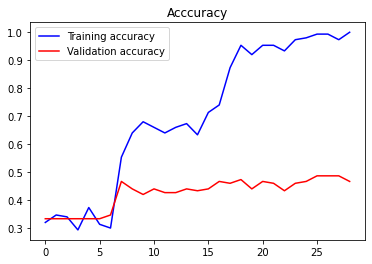

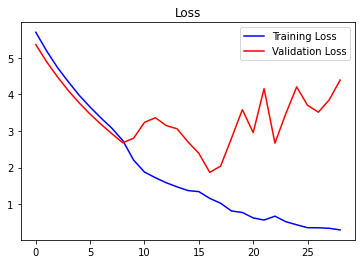

In [118]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Acccuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [119]:
# Inference
text = list_tweet
seq =  tokenizer.texts_to_sequences([text])
pad = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predicted = np.argmax(model.predict(pad, verbose=0))
target_index_word[predicted].split("\n")

['Pariwisata Kuliner']

In [120]:
# Saves model to .h5 format
model.save(root_path + '/model/model.h5')

# tflite converter and the optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Converts model to .tflite format
tfmodel = converter.convert()
open(root_path + '\model\model.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\Aliif\AppData\Local\Temp\tmp947qqrkj\assets


INFO:tensorflow:Assets written to: C:\Users\Aliif\AppData\Local\Temp\tmp947qqrkj\assets


6031392